In [94]:
import spacy
import spacy_transformers
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
import pandas as pd
import re
import os
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import pyLDAvis.gensim_models
import warnings
from tqdm import tqdm
from mistralai import Mistral
import time
from gensim.models import CoherenceModel
from bertopic import BERTopic
#from umap import UMAP #si pas de gpu compatible cuda
#from hdbscan import HDBSCAN # si pas de gpu compatible cuda
from cuml.cluster import HDBSCAN #si gpu compatible cuda
from cuml.manifold import UMAP #si gpu compatible cuda
from bertopic.representation import PartOfSpeech
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance
from sklearn.feature_extraction.text import CountVectorizer
from scipy.cluster import hierarchy as sch
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

In [3]:
try:
    nlp = spacy.load("fr_core_news_lg")
except OSError:
    !python -m spacy download fr_core_news_lg
    nlp = spacy.load("fr_core_news_lg")

In [4]:
my_stop = ["janvier", "février", "fevrier", "mars", "avril", "mai", "juin", "juillet", "août", "aout", "septembre", "octobre", "novembre", "décembre",
           "je", "tu", "il", "elle", "nous", "vous", "ils", "elles", "ça", "c'", "ce", "cela", "ceci", "moi", "toi", "lui", "sien", "leur", 
          "faire", "être", "avoir", "mettre", "aller", "devoir", "vouloir", "falloir", "devenir", "luire", "pouvoir", "savoir", "demeurer", "sembler",
           "passer", "voir", "venir", "prendre", "trouver", "raconter", "déclarer",
           "expliquer", "dire", "annoncer", "confirmer", 
          "sont", "est", "a", "ont", "vont", "seraient", "seront",
          "jusque", "mais", "et", "donc", "or", "ni", "car", "jusqu", "jusqu'", "bien", "mal", "presque", "jusqu’",
          "an", "année", "jour", "mois",
          "...", "non", "oui", "presscontact",
          "lundi", "mardi", "mercredi", "jeudi", "vendredi", "samedi", "dimanche", "hier", "demain", "aujourd'hui",
          "abonné", "m.", "mme", "ici", "-t", "là", "là-bas", "-là", "cas", "trop",
          "premier", "deuxième", "troisième", "dernier", "prochain",
          "toujours", "jamais", "parfois",
          "abonné", "article", "réservé", "e.a.", "s.t.",
          "grand", "petit", "gros", "large",
          "afp", "belga", "the", "rien", "conseiller", "rédaction", "figaro",
          "femme", "homme",
           "évident", "judicieux"
          #"prostitué", "prostituée", "prostitution", "prostituer",
          'antérieur', 'toi', 'lors', 'il', 'moindres', 'pres', 'chaque', 'avaient', 'vôtre', 'parfois', 'siens', 'quel', 'nos', 'restant', 'restent', 'toi-même', "c'", 'jusque', 'la', 'm’', 'lesquels', 'anterieures', 'pourrais', 'chez', 'en', 'vous-mêmes', 'huit', 'envers', 'celles-là', 'tout', 'suis', 'douzième', 'certes', 'apres', 'moins', 'cinquième', 'était', 'ouvert', 'etaient', 'reste', 'directe', 'nôtres', 'leurs', 'on', 'd’', 'doivent', 'anterieure', 'différents', 'hi', 'deux', 'etant', 'lès', 'avait', 'ha', 'dont', 'être', 'ma', 'dix-neuf', 'elle', 'toute', 'auquel', 'sept', 'desquelles', 'etc', 'ça', 'dans', 'alors', 'sera', 'parmi', 'nous-mêmes', 'plutôt', 'vous', 'auront', 'stop', 'certain', 'seules', 'basee', 'préalable', 'devant', 'anterieur', 'allaient', 'c’', 'quelconque', 'onze', 'excepté', 'font', 'façon', 'étais', 'le', 'delà', 'lesquelles', 'ceux', 'neuvième', 'vôtres', 'auxquels', 'où', 'votres', 'prealable', 'toujours', 'eux', 'malgre', 'doit', 'toi-meme', 'siennes', 'y', "n'", 'ait', 's’', 'ne', 'quatre', 'cinquantaine', 'pendant', 'vé', 'elles', 'celui-la', 'té', 'qui', 'ayant', 'aurait', 'avoir', 'cent', 'ce', 'nombreux', 'suit', 'seuls', 'quelle', 'sent', 'voilà', 'votre', 'spécifique', 'différent', 'tels', 'aupres', 'seule', 'fait', 'attendu', 'huitième', 'vos', 'dire', 'depuis', 'nouveau', 'soi-meme', 'suivant', 'à', 'seul', 'suffit', 'des', 'rend', 'pu', 'pas', 'comme', 'tant', 'eh', 'j’', 'moi-même', "qu'", 'deuxièmement', 'ai', 'eu', 'tente', 'i', 'ceux-ci', 'ta', 'également', 'étant', 'celles-la', 'chacun', "s'", 'vas', 'fais', 'enfin', 'leur', 'suivre', 'auxquelles', 'trente', 'quelles', 'ouverts', 'seraient', 'suivants', 'tienne', 'relative', 'celle', 'toutes', 'environ', 'meme', 'malgré', 'moi', 'souvent', 'merci', 'six', 'differente', 'quatre-vingt', 'importe', 'specifique', 'aux', 'tend', 'est', 'possible', 'celles', 'elle-meme', 'ceux-là', 'désormais', 'mien', 'trois', 'soixante', 'quatrièmement', 'seize', 'neanmoins', 'vu', 'da', 'autres', 'quinze', 'pouvait', 'egalement', 'n’', 'puis', 'dedans', 'surtout', 'une', 'divers', 'là', 'tiens', 'puisque', 'néanmoins', 'dix-huit', 'dehors', 'effet', 'lorsque', 'vais', 'peut', 'tu', 'comment', 'les', 'lui-meme', 'premier', 'selon', 'combien', 'cela', 'faisaient', 'revoilà', 'hui', 'déja', 'sans', 'certaines', 'tous', 'concernant', 'lequel', 'certains', 'te', 'un', 'je', 'etais', 'va', 'avant', 'quelque', 'hep', 'l’', 'compris', 'proche', 'pense', 'si', 'plusieurs', 'du', 'différentes', 'me', 'au', 'cinquante', 'autrement', 'plus', 'durant', 'onzième', 'cet', 'cinq', 'car', 'memes', 'mon', 'nombreuses', 'parle', 'sous', 'première', 'soi', 'semblable', 'ces', 'sien', 'vers', 'hem', 'derrière', 'donc', 'ni', 'sienne', 'debout', 'ainsi', 'celle-ci', 'eux-mêmes', 'semblaient', 'es', 'soi-même', 'quelques', 'procedant', 'tellement', 'telles', 'mes', "d'", 'pour', 'tenir', 'treize', 'plutot', 'seront', 'cinquantième', 'certaine', 'faisant', 'elles-memes', 'celui-ci', 'partant', 'uns', 'celles-ci', 'antérieure', 'suivante', "t'", 'laisser', 'dit', 'mienne', 'ouias', 'chacune', 'ès', 'dits', 'unes', 'ci', 'derriere', 'hou', 'retour', 'spécifiques', 'laquelle', 'quand', 'tes', 'tres', 'houp', 'directement', 'voila', 'mille', 'miennes', 'septième', 'bat', 'différente', 'assez', 'autrui', 'cependant', 'antérieures', 'pourrait', 'elles-mêmes', 'devra', 'quiconque', 'voici', 'feront', 'douze', 'exactement', 'aussi', 'ceci', 'gens', 'et', 'longtemps', 'ses', 'etre', 'different', 'hé', 'aura', 'dessus', 'devers', 'quatorze', "j'", 'allons', 'soit', 'aie', "l'", 'hormis', 'premièrement', 'rendre', 'vingt', 'sait', 'quatrième', 'diverse', 'tel', 'dite', 'touchant', 'étaient', 'ont', 'ouste', 'desormais', 'quant-à-soi', 'semble', 'nous', 'peu', 'via', 'diverses', 'dessous', 'se', 'mêmes', 'sinon', 'telle', 'dix-sept', 'quoi', 'son', 'troisièmement', 'semblent', 'nul', 'déjà', 'bas', 'hue', 'peuvent', 'lui-même', 'qu’', 'differentes', 'mais', 'celle-la', 'ils', 'â', 'quarante', 'abord', 'près', 'a', 'pourquoi', 'seulement', 'moi-meme', 'celui-là', 'ouverte', 'desquels', 'dixième', 'dix', 'sur', 'auraient', 'duquel', 'même', 'nôtre', 'suffisante', 'dejà', 'dès', 'relativement', 'avais', 't’', 'deja', 'maint', 'personne', 'peux', 'ho', 'sixième', 'specifiques', 'suivantes', 'que', 'avons', 'entre', 'o', 'tiennes', 'ton', 'differents', 'elle-même', 'as', 'permet', 'parlent', 'precisement', 'outre', 'lui', 'maintenant', 'quels', "m'", 'ah', 'serait', 'autre', 'quant', 'tien', 'cette', 'sa', 'précisement', 'celle-là', 'vont', 'possibles', 'afin', 'troisième', 'miens', 'encore', 'ou', 'sont', "quelqu'un", 'etait', 'juste', 'deuxième', 'de', 'parler', 'sauf', 'revoila', 'na', 'notamment', 'or', 'très', 'facon', 'ô', 'avec', 'notre', 'revoici', 'par', 'après', 'tenant', 'jusqu', 'parce', 'hors', 'suffisant', 'quoique', 'celui']

verbes_d_etat = ['accorder', 'affecter', 'afficher', 'allouer', 'apparaître', 'appartenir', 'assigner', 'attester', 'attribuer', 'avoir', 'choisir', 'communiquer', 'comprendre', 'compter', 'concerner', 'concéder', 'confier', 'consacrer', 'consister', 'constituer', 'contenir', 'demeurer', 'destiner', 'devenir', 'diffuser', 'dispatcher', 'disposer', 'distribuer', 'décider', 'dédier', 'démontrer', 'désigner', 'déterminer', 'dévoiler', 'exister', 'exposer', 'exprimer', 'fixer', 'impliquer', 'imprimer', 'inclure', 'indiquer', 'installer', 'introduire', 'localiser', 'manifester', 'montrer', 'nommer', 'octroyer', 'opter', 'paraître', 'partager', 'placer', 'positionner', 'posséder', 'prouver', 'préférer', 'présenter', 'publier', 'regarder', 'remettre', 'renfermer', 'représenter', 'rester', 'répartir', 'réserver', 'révéler', 'sembler', 'signifier', 'situer', 'symboliser', 'sélectionner', 'toucher', 'transmettre', 'témoigner', 'valoir', 'vouer', 'éditer', 'élire', 'établir', 'être']

my_stop.extend(verbes_d_etat)

In [5]:

my_stop.extend(list(fr_stop))

In [6]:
def clean_text(text):
    motifs = [r"\b(\d{1,2}h(?:\d{2})?)\b", #heures
              r"\b(\d{1,2} heures)\b", #heures toutes lettres
              r"\b(\d{2}/\d{2}/\d{2,4}|\d{2} (janvier|février|mars|avril|mai|juin|juillet|août|septembre|octobre|novembre|décembre) \d{4})\b" #dates
              r"\d"
             ]
    for motif in motifs:
        text = re.sub(motif, '', text)
    return text

In [7]:
def import_txt(directory):
    txt_files = os.listdir(directory)
    articles = []
    journaux = []
    years = []
    months = []
    for txt in txt_files:
        try:
            with open(os.path.join(directory, txt), 'r', encoding='utf-8') as f:
                articles.append(clean_text(f.read()))
            cat, pol, auth, year, month, name = txt.split('_')
            journaux.append(auth)
            years.append(year)
            months.append(month)
        except OSError:
            print(colored(f"Erreur lors de l'ouverture/lecture du fichier {txt}.", 'red'))
    d = {'texte': articles, 'journal': journaux, 'année':years, 'mois':months}
    return pd.DataFrame(data = d, columns = ['texte', 'journal', 'année', 'mois'])

In [8]:
def tokenize_df(df, my_stop):
    txt = df['texte']
    docs = []
    for doc in tqdm(nlp.pipe(txt), total=len(txt)):
        tokens = []
        for token in doc:
            if len(token.orth_) > 2 and not token.lemma_.lower() in my_stop and not token.pos_ == 'PROPN': # supprime les mots 
                tokens.append( token.lemma_.lower() )
        docs.append(tokens)
    return docs

In [9]:
def find_bigram(tokens):
    bigram = Phrases(tokens, min_count=5)

    for index in range(len(tokens)):
        for token in bigram[tokens[index]]:
            if '_' in token:  # les bigrammes peuvent être reconnus par "_" qui concatène les mots
                tokens[index].append(token)
    return tokens

In [10]:
def doc2bow(bigrams):
    dictionary = Dictionary(bigrams)
    print('Nombre de mots unique dans les documents initiaux :', len(dictionary))

    dictionary.filter_extremes(no_below=2, no_above=0.90)
    print('Nombre de mots unique dans les documents après avoir enlevé les mots fréquents/peu fréquents :', len(dictionary))

    #print("Exemple :", dictionary.doc2bow(bigrams[4]))
    corpus = [ dictionary.doc2bow(doc) for doc in bigrams]
    return corpus, dictionary

In [11]:
def get_df(year:str):
    df = pd.DataFrame(columns = ['texte', 'journal', 'année', 'mois'])
    path = 'Sources/Europresse/txt/'
    for month in range(1, 13):
        month = str(month) if month > 9 else '0' + str(month)
        folder = path + month + '_' + year
        df_temp = import_txt(folder)
        df = pd.concat([df, df_temp], ignore_index=True)
    return df

In [12]:
def get_param(year:str, my_stop):
    print("Génération du dataframe")
    df = get_df(year)
    print("Tokenization du dataframe")
    tokens = tokenize_df(df, my_stop)
    print("Etablissement des bigrams")
    bigrams = find_bigram(tokens)
    print("Constitution du corpus et du dictionnaire")
    corpus, dictionary = doc2bow(bigrams)
    return df, tokens, bigrams, corpus, dictionary

In [13]:
def get_visu(corpus, dictionary, year:str):
    model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=14, chunksize=1000, passes=10, random_state=26112002)
    vis_data = pyLDAvis.gensim_models.prepare(model, corpus, dictionary, sort_topics=False)
    pyLDAvis.save_html(vis_data, 'html/LDA_' + year + '.html')
    return model        

In [14]:
def init_client():
    api_key = os.environ["MISTRAL_API_KEY"]
    model = "mistral-large-latest"

    client = Mistral(api_key=api_key)
    return client

In [15]:
def get_topic_name(words:str, client):
    chat_response = client.chat.complete(
    model= "mistral-large-latest",
    messages = [
            {
            "role": "user",
            "content": f"""J'essaie de déterminer les sujets traités par des articles de journaux. Je vais te donner 20 mots qui sont représentatifs du sujet. Donne moi le thème abordé par les journaux en un ou deux groupes nominaux.

                            Les mots: {words}

                            Ne donne que le thème, n'ajoute rien d'autre""",
            },
        ]
    )
    
    return chat_response.choices[0].message.content

In [16]:
def find_topics(words_topic, client):
    topics = []
    for i, words in enumerate(words_topic):
        try:
            topics.append(get_topic_name(words, client))
            time.sleep(2)
        except SDKError:
            print(f"Erreur lors de la communication avec le LLM lors du traitement du {i}e sujet" ) 
    return topics   

In [17]:
def get_topics_full(model):
    words_topic = []
    for (topic, words) in model.print_topics(num_words=20):
        words = re.sub(r" \+ ", ', ', words)
        words = re.sub(r"\d.\d{3}\*", "", words)
        words_topic.append(words)
    client = init_client()
    topics = find_topics(words_topic, client)
    return topics

In [18]:
def get_visu(corpus, dictionary, year:str):
    model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=14, chunksize=1000, passes=10, random_state=26112002)
    vis_data = pyLDAvis.gensim_models.prepare(model, corpus, dictionary, sort_topics=False)
    pyLDAvis.save_html(vis_data, 'html/LDA_' + year + '.html')
    return model        

In [19]:
df20, tokens20, bigrams20, corpus20, dictionary20 = get_param('2020', my_stop)

Génération du dataframe
Tokenization du dataframe


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6901/6901 [07:18<00:00, 15.73it/s]


Etablissement des bigrams
Constitution du corpus et du dictionnaire
Nombre de mots unique dans les documents initiaux : 73292
Nombre de mots unique dans les documents après avoir enlevé les mots fréquents/peu fréquents : 41838


In [40]:
dict2020 = {'df':df20,
          'tokens':tokens20,
          'bigrams':bigrams20,
          'corpus':corpus20,
          'dictionary':dictionary20}

with open("Sources/Europresse/pyData/dict/dict2020.bin", "wb") as f:
    pickle.dump(dict2020, f)

In [41]:
dict2019 = {'df':df19,
          'tokens':tokens19,
          'bigrams':bigrams19,
          'corpus':corpus19,
          'dictionary':dictionary19}

with open("Sources/Europresse/pyData/dict/dict2019.bin", "wb") as f:
    pickle.dump(dict2019, f)

In [42]:
dict2021 = {'df':df21,
          'tokens':tokens21,
          'bigrams':bigrams21,
          'corpus':corpus21,
          'dictionary':dictionary21}

with open("Sources/Europresse/pyData/dict/dict2021.bin", "wb") as f:
    pickle.dump(dict2021, f)

In [43]:
dict2022 = {'df':df22,
          'tokens':tokens22,
          'bigrams':bigrams22,
          'corpus':corpus22,
          'dictionary':dictionary22}

with open("Sources/Europresse/pyData/dict/dict2022.bin", "wb") as f:
    pickle.dump(dict2022, f)

In [44]:
dict2023 = {'df':df23,
          'tokens':tokens23,
          'bigrams':bigrams23,
          'corpus':corpus23,
          'dictionary':dictionary23}

with open("Sources/Europresse/pyData/dict/dict2023.bin", "wb") as f:
    pickle.dump(dict2023, f)

In [45]:
dict2024 = {'df':df24,
          'tokens':tokens24,
          'bigrams':bigrams24,
          'corpus':corpus24,
          'dictionary':dictionary24}

with open("Sources/Europresse/pyData/dict/dict2024.bin", "wb") as f:
    pickle.dump(dict2024, f)

In [64]:
model = LdaModel(corpus=corpus20, id2word=dictionary20, num_topics=5, chunksize=1000, passes=10, random_state=26112002)
vis_data = pyLDAvis.gensim_models.prepare(model, corpus20, dictionary20, sort_topics=False)

In [48]:
pyLDAvis.enable_notebook()

In [56]:
df20['texte']

0        CHARLEROI Le cadavre d'une dame dans les toil...
1        20 Minutes avec AFP GOUVERNEMENT Dimanche soi...
2        Dylan Robert, l'acteur césarisé rattrapé pour...
3        La bande bruxelloise a "acheté" la jeune femm...
4        Brive Les  cinq  prévenus  dans  l'affaire  d...
                              ...                        
7778     La vérité est au fond du Kerr Julie Malaure O...
7779     Belga; Belga (BELGA) = Le parquet de Bruxelle...
7780     Genève, 29 déc  (AFP) - - Le Comité des droit...
7781     '' Le premier confinement a été une période t...
7782     Le tribunal correctionnel de Tournai a condam...
Name: texte, Length: 7783, dtype: object

In [65]:
coherence_model_lda = CoherenceModel(model=model, texts=tokens20, dictionary=dictionary20, coherence='c_v')

In [66]:
coherence_model_lda.get_coherence()

0.46728214936436735

In [24]:
best_model20 = LdaModel(corpus=corpus20, id2word=dictionary20, num_topics=5, chunksize=1000, passes=10, random_state=26112002)
best_coherence20 = CoherenceModel(model=best_model, texts=tokens20, dictionary=dictionary20, coherence='c_v').get_coherence()
best_num_topic20 = 5
coherence_list20 = []
num_topic_list20 = list(range(5,75))
coherence_list20.append(best_coherence20)
for num_topic in range(6,75):
    print(f"Processing training with {num_topic} topics")
    current_model = LdaModel(corpus=corpus20, id2word=dictionary20, num_topics=num_topic, chunksize=1000, passes=10, random_state=26112002)
    current_coherence = CoherenceModel(model=current_model, texts=tokens20, dictionary=dictionary20, coherence='c_v').get_coherence()
    coherence_list20.append(current_coherence)
    if current_coherence > best_coherence20:
        best_coherence20 = current_coherence
        best_model20 = current_model
        best_num_topic20 = num_topic

Processing training with 6 topics
Processing training with 7 topics
Processing training with 8 topics
Processing training with 9 topics
Processing training with 10 topics
Processing training with 11 topics
Processing training with 12 topics
Processing training with 13 topics
Processing training with 14 topics
Processing training with 15 topics
Processing training with 16 topics
Processing training with 17 topics
Processing training with 18 topics
Processing training with 19 topics
Processing training with 20 topics
Processing training with 21 topics
Processing training with 22 topics
Processing training with 23 topics
Processing training with 24 topics
Processing training with 25 topics
Processing training with 26 topics
Processing training with 27 topics
Processing training with 28 topics
Processing training with 29 topics
Processing training with 30 topics
Processing training with 31 topics
Processing training with 32 topics
Processing training with 33 topics
Processing training with

In [26]:
best_coherence

0.5737858816862409

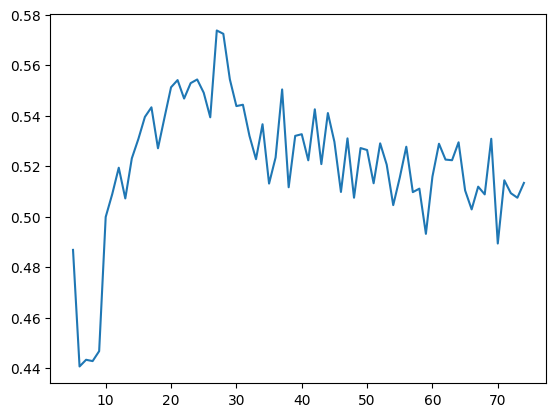

In [28]:
plt.plot(num_topic_list, coherence_list)

In [29]:
best_model.print_topics(num_words=20)

[(6,
  '0.023*"affaire" + 0.016*"accuser" + 0.016*"américain" + 0.016*"sexuel" + 0.014*"financier" + 0.014*"mineure" + 0.014*"accusation" + 0.012*"fédéral" + 0.011*"britannique" + 0.010*"enquête" + 0.010*"relation" + 0.009*"justice" + 0.009*"trafic" + 0.009*"document" + 0.009*"dollar" + 0.008*"procureur" + 0.008*"affirmer" + 0.008*"ancien" + 0.008*"inculper" + 0.008*"fille"'),
 (2,
  '0.008*"vie" + 0.005*"jeune" + 0.005*"temps" + 0.005*"fois" + 0.005*"monde" + 0.004*"enfant" + 0.004*"entrer" + 0.004*"mère" + 0.004*"bon" + 0.004*"père" + 0.004*"famille" + 0.004*"vivre" + 0.003*"histoire" + 0.003*"sortir" + 0.003*"aimer" + 0.003*"arriver" + 0.003*"connaître" + 0.003*"sou" + 0.003*"retrouver" + 0.003*"perdre"'),
 (14,
  '0.105*"fille" + 0.056*"jeune_fille" + 0.053*"jeune" + 0.017*"prostitution" + 0.014*"mineure" + 0.011*"prostituer" + 0.011*"bulgare" + 0.010*"retrouver" + 0.010*"dossier" + 0.010*"fugueur" + 0.009*"vendre" + 0.009*"adolescent" + 0.007*"victime" + 0.007*"français" + 0.007*"

In [45]:
tokens20

[['cadavre',
  'dame',
  'toilette',
  'l.c.',
  'charleroi',
  'cadavre',
  'dame',
  'toilette',
  'matin',
  'corps',
  'vie',
  'dame',
  'âgé',
  'quarantaine',
  'découvrir',
  'toilette',
  'public',
  'établissement',
  'hospitalier',
  'enquête',
  'ouvrir',
  'indique',
  'parquet',
  'élément',
  'aucun',
  'signe',
  'intervention',
  'extérieur',
  'découvrir',
  'médecin',
  'légiste',
  'précaution',
  'examiner',
  'corps',
  'cause',
  'précis',
  'décès',
  'victime',
  'connaître',
  'prostitution',
  'toxicomanie',
  'toilette_public',
  'établissement_hospitalier',
  'enquête_ouvrir',
  'indique_parquet',
  'médecin_légiste',
  'prostitution_toxicomanie'],
 ['minute',
  'gouvernement',
  'soir',
  'zone',
  'interdire',
  'documentaire',
  'choc',
  'prise',
  'charge',
  'enfant',
  'documentaire',
  'zone',
  'interdire',
  'prise',
  'charge',
  'enfant',
  'secrétaire',
  'etat',
  'charger',
  'protection',
  'enfance',
  'reconnaître',
  'communiqué',
  'entr

In [21]:
model20 = get_visu(corpus20, dictionary20, '2020')

In [32]:
topics20 = get_topics_full(model20)

In [33]:
topics20

['Programmation de films, cinéma',
 'Législation sur la prostitution, Politique de santé publique',
 'Mouvement féministe, Politique',
 'Conflits militaires, islamisme',
 'Industrie du divertissement, cinéma et musique',
 '\n\nProgrammestélévisés, séries et téléfilms',
 'Lutte contre la prostitution des jeunes',
 'Prostitution de mineurs, enquête judiciaire',
 'Littérature, histoire',
 'Musique et chanteurs célèbres',
 'Affaire criminelle, enquête policière',
 'Le procès de Jeffrey Epstein et Ghislaine Maxwell.',
 'Vie urbaine à Paris',
 'Cinéma et vie familiale']

In [30]:
df21, tokens21, bigrams21, corpus21, dictionary21 = get_param('2021', my_stop)

Génération du dataframe
Tokenization du dataframe


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8734/8734 [08:54<00:00, 16.34it/s]


Etablissement des bigrams
Constitution du corpus et du dictionnaire
Nombre de mots unique dans les documents initiaux : 76703
Nombre de mots unique dans les documents après avoir enlevé les mots fréquents/peu fréquents : 52674


In [35]:
model21 = get_visu(corpus21, dictionary21, '2021')

In [36]:
topics21 = get_topics_full(model21)

In [37]:
topics21

['Procès judiciaire, politique nationale',
 'Lutte contre la prostitution, aide sociale aux jeunes',
 'Violence sexuelle contre les mineurs',
 'Urbanisme et sécurité publique',
 'Affaire Jeffrey Epstein, Ghislaine Maxwell',
 'Prostitution et proxénétisme',
 'Littérature, arts de la scène',
 'Justice parlementaire à Bruxelles',
 'Cinéma, notamment le film "Le Silence des agneaux" et son actrice Jodie Foster.',
 'Militantisme féministe, droits sociaux',
 'Relations internationales en Asie',
 'Procès de Valérie Bacot, Affaire de justice',
 "L'industrie du cinéma et des séries télévisées",
 'Vie de famille']

In [31]:
df22, tokens22, bigrams22, corpus22, dictionary22 = get_param('2022', my_stop)

Génération du dataframe
Tokenization du dataframe


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9094/9094 [10:10<00:00, 14.89it/s]


Etablissement des bigrams
Constitution du corpus et du dictionnaire
Nombre de mots unique dans les documents initiaux : 94872
Nombre de mots unique dans les documents après avoir enlevé les mots fréquents/peu fréquents : 60954


In [39]:
model22 = get_visu(corpus22, dictionary22, '2022')

In [40]:
topics22 = get_topics_full(model22)

In [41]:
topics22

['Événements culturels, spectacles de théâtre',
 'Séries télévisées, diffusion',
 'Conflits internationaux, élections politiques',
 'Prostitution et proxénétisme, enquêtes judiciaires.',
 'Traite des êtres humains, Violence sexuelle sur mineurs',
 'Cinéma et festivals de films',
 'Cinéma',
 'procès judiciaire, système judiciaire français',
 'Variole du singe, vaccination',
 'Prostitution, violence sexuelle',
 'Exploitation sexuelle, accusations criminelles',
 'Littérature et histoire',
 'Arts et patrimoine culturel',
 'Problèmes sociaux en milieu urbain']

In [32]:
df23, tokens23, bigrams23, corpus23, dictionary23 = get_param('2023', my_stop)

Génération du dataframe
Tokenization du dataframe


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9373/9373 [10:06<00:00, 15.45it/s]


Etablissement des bigrams
Constitution du corpus et du dictionnaire
Nombre de mots unique dans les documents initiaux : 86182
Nombre de mots unique dans les documents après avoir enlevé les mots fréquents/peu fréquents : 60166


In [43]:
model23 = get_visu(corpus23, dictionary23, '2023')

In [44]:
topics23 = get_topics_full(model23)

In [45]:
topics23

['Johnny Hallyday, Laeticia Hallyday',
 'Actualités régionales',
 'Affaire politique américaine, Relations internationales États-Unis',
 'Industrie cinématographique et télévisuelle',
 'Littérature et arts',
 'Le trafic de drogue, les gangs criminels',
 'Procès judiciaire de Silvio Berlusconi',
 'Violences sexuelles',
 'Prostitution et proxénétisme',
 'Lutte contre la prostitution des jeunes de la rue',
 'Patrimoine urbain, événements historiques',
 'Famille, vie quotidienne',
 'Prostitution urbaine, politique municipale',
 'Arts et culture']

In [33]:
df24, tokens24, bigrams24, corpus24, dictionary24 = get_param('2024', my_stop)

Génération du dataframe
Tokenization du dataframe


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15685/15685 [15:52<00:00, 16.47it/s]


Etablissement des bigrams
Constitution du corpus et du dictionnaire
Nombre de mots unique dans les documents initiaux : 98332
Nombre de mots unique dans les documents après avoir enlevé les mots fréquents/peu fréquents : 86016


In [48]:
model24 = get_visu(corpus24, dictionary24, '2024')

In [49]:
topics24 = get_topics_full(model24)

In [50]:
topics24

['Procès pour agression sexuelle',
 'Vie urbaine',
 'Littérature, roman',
 'La prostitution des mineurs',
 'Trafic de drogue international, réseaux criminels.',
 'Programmes télévisés et cinéma.',
 'Arts et culture',
 'Violence criminelle et enquêtes judiciaires',
 'La Révolution française, la politique républicaine',
 'Violence sexuelle, Abus familial',
 'Service client, gestion des questions',
 'Enquête sur Donald Trump et Matt Gaetz',
 'Cinéma, festival de Cannes',
 'Prostitution de mineurs, réseaux de proxénétisme']

In [34]:
df19, tokens19, bigrams19, corpus19, dictionary19 = get_param('2019', my_stop)

Génération du dataframe
Tokenization du dataframe


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6910/6910 [06:08<00:00, 18.74it/s]


Etablissement des bigrams
Constitution du corpus et du dictionnaire
Nombre de mots unique dans les documents initiaux : 65016
Nombre de mots unique dans les documents après avoir enlevé les mots fréquents/peu fréquents : 39306


In [36]:
print("2019")
best_model19 = LdaModel(corpus=corpus19, id2word=dictionary19, num_topics=5, chunksize=1000, passes=10, random_state=26112002)
best_coherence19 = CoherenceModel(model=best_model19, texts=tokens19, dictionary=dictionary19, coherence='c_v').get_coherence()
best_num_topic19 = 5
coherence_list19 = []
num_topic_list19 = list(range(5,76))
coherence_list19.append(best_coherence19)
for num_topic in range(6,76):
    print(f"Processing training with {num_topic} topics")
    current_model = LdaModel(corpus=corpus19, id2word=dictionary19, num_topics=num_topic, chunksize=1000, passes=10, random_state=26112002)
    current_coherence = CoherenceModel(model=current_model, texts=tokens19, dictionary=dictionary19, coherence='c_v').get_coherence()
    coherence_list19.append(current_coherence)
    if current_coherence > best_coherence19:
        best_coherence19 = current_coherence
        best_model19 = current_model
        best_num_topic19 = num_topic
        
print("2020")
best_model20 = LdaModel(corpus=corpus20, id2word=dictionary20, num_topics=5, chunksize=1000, passes=10, random_state=26112002)
best_coherence20 = CoherenceModel(model=best_model20, texts=tokens20, dictionary=dictionary20, coherence='c_v').get_coherence()
best_num_topic20 = 5
coherence_list20 = []
num_topic_list20 = list(range(5,76))
coherence_list20.append(best_coherence20)
for num_topic in range(6,76):
    print(f"Processing training with {num_topic} topics")
    current_model = LdaModel(corpus=corpus20, id2word=dictionary20, num_topics=num_topic, chunksize=1000, passes=10, random_state=26112002)
    current_coherence = CoherenceModel(model=current_model, texts=tokens20, dictionary=dictionary20, coherence='c_v').get_coherence()
    coherence_list20.append(current_coherence)
    if current_coherence > best_coherence20:
        best_coherence20 = current_coherence
        best_model20 = current_model
        best_num_topic20 = num_topic

print("2021")
best_model21 = LdaModel(corpus=corpus21, id2word=dictionary21, num_topics=5, chunksize=1000, passes=10, random_state=26112002)
best_coherence21 = CoherenceModel(model=best_model21, texts=tokens21, dictionary=dictionary21, coherence='c_v').get_coherence()
best_num_topic21 = 5
coherence_list21 = []
num_topic_list21 = list(range(5,76))
coherence_list21.append(best_coherence21)
for num_topic in range(6,76):
    print(f"Processing training with {num_topic} topics")
    current_model = LdaModel(corpus=corpus21, id2word=dictionary21, num_topics=num_topic, chunksize=1000, passes=10, random_state=26112002)
    current_coherence = CoherenceModel(model=current_model, texts=tokens21, dictionary=dictionary21, coherence='c_v').get_coherence()
    coherence_list21.append(current_coherence)
    if current_coherence > best_coherence21:
        best_coherence21 = current_coherence
        best_model21 = current_model
        best_num_topic21 = num_topic

print("2022")
best_model22 = LdaModel(corpus=corpus22, id2word=dictionary22, num_topics=5, chunksize=1000, passes=10, random_state=26112002)
best_coherence22 = CoherenceModel(model=best_model22, texts=tokens22, dictionary=dictionary22, coherence='c_v').get_coherence()
best_num_topic22 = 5
coherence_list22 = []
num_topic_list22 = list(range(5,76))
coherence_list22.append(best_coherence22)
for num_topic in range(6,76):
    print(f"Processing training with {num_topic} topics")
    current_model = LdaModel(corpus=corpus22, id2word=dictionary22, num_topics=num_topic, chunksize=1000, passes=10, random_state=26112002)
    current_coherence = CoherenceModel(model=current_model, texts=tokens22, dictionary=dictionary22, coherence='c_v').get_coherence()
    coherence_list22.append(current_coherence)
    if current_coherence > best_coherence22:
        best_coherence22 = current_coherence
        best_model22 = current_model
        best_num_topic22 = num_topic

print("2023")
best_model23 = LdaModel(corpus=corpus23, id2word=dictionary23, num_topics=5, chunksize=1000, passes=10, random_state=26112002)
best_coherence23 = CoherenceModel(model=best_model23, texts=tokens23, dictionary=dictionary23, coherence='c_v').get_coherence()
best_num_topic23 = 5
coherence_list23 = []
num_topic_list23 = list(range(5,76))
coherence_list23.append(best_coherence23)
for num_topic in range(6,76):
    print(f"Processing training with {num_topic} topics")
    current_model = LdaModel(corpus=corpus23, id2word=dictionary23, num_topics=num_topic, chunksize=1000, passes=10, random_state=26112002)
    current_coherence = CoherenceModel(model=current_model, texts=tokens23, dictionary=dictionary23, coherence='c_v').get_coherence()
    coherence_list23.append(current_coherence)
    if current_coherence > best_coherence23:
        best_coherence23 = current_coherence
        best_model23 = current_model
        best_num_topic23 = num_topic

print("2024")
best_model24 = LdaModel(corpus=corpus24, id2word=dictionary24, num_topics=5, chunksize=1000, passes=10, random_state=26112002)
best_coherence24 = CoherenceModel(model=best_model24, texts=tokens24, dictionary=dictionary24, coherence='c_v').get_coherence()
best_num_topic24 = 5
coherence_list24 = []
num_topic_list24 = list(range(5,76))
coherence_list24.append(best_coherence24)
for num_topic in range(6,76):
    print(f"Processing training with {num_topic} topics")
    current_model = LdaModel(corpus=corpus24, id2word=dictionary24, num_topics=num_topic, chunksize=1000, passes=10, random_state=26112002)
    current_coherence = CoherenceModel(model=current_model, texts=tokens24, dictionary=dictionary24, coherence='c_v').get_coherence()
    coherence_list24.append(current_coherence)
    if current_coherence > best_coherence24:
        best_coherence24 = current_coherence
        best_model24 = current_model
        best_num_topic24 = num_topic

2019
Processing training with 6 topics
Processing training with 7 topics
Processing training with 8 topics
Processing training with 9 topics
Processing training with 10 topics
Processing training with 11 topics
Processing training with 12 topics
Processing training with 13 topics
Processing training with 14 topics
Processing training with 15 topics
Processing training with 16 topics
Processing training with 17 topics
Processing training with 18 topics
Processing training with 19 topics
Processing training with 20 topics
Processing training with 21 topics
Processing training with 22 topics
Processing training with 23 topics
Processing training with 24 topics
Processing training with 25 topics
Processing training with 26 topics
Processing training with 27 topics
Processing training with 28 topics
Processing training with 29 topics
Processing training with 30 topics
Processing training with 31 topics
Processing training with 32 topics
Processing training with 33 topics
Processing training

In [50]:
print(f"""2019: {best_num_topic19} topics à {best_coherence19},
2020: {best_num_topic20} topics à {best_coherence20},
2021: {best_num_topic21} topics à {best_coherence21},
2022: {best_num_topic22} topics à {best_coherence22},
2023: {best_num_topic23} topics à {best_coherence23},
2024: {best_num_topic24} topics à {best_coherence24}""")

2019: 24 topics à 0.5660462992023527,
2020: 27 topics à 0.5737858816862409,
2021: 32 topics à 0.5723823636478884,
2022: 7 topics à 0.6107315405929468,
2023: 22 topics à 0.5574819826783688,
2024: 16 topics à 0.5584207122578607


In [37]:
import pickle

In [38]:
with open("Sources/Europresse/pyData/model/model2019.bin", "wb") as f:
    pickle.dump(best_model19, f)

with open("Sources/Europresse/pyData/model/model2020.bin", "wb") as f:
    pickle.dump(best_model20, f)

with open("Sources/Europresse/pyData/model/model2021.bin", "wb") as f:
    pickle.dump(best_model21, f)

with open("Sources/Europresse/pyData/model/model2022.bin", "wb") as f:
    pickle.dump(best_model22, f)

with open("Sources/Europresse/pyData/model/model2023.bin", "wb") as f:
    pickle.dump(best_model23, f)

with open("Sources/Europresse/pyData/model/model2024.bin", "wb") as f:
    pickle.dump(best_model24, f)

In [63]:
with open("Sources/Europresse/pyData/tokens_LDA_2020.bin", "wb") as f:
    pickle.dump(tokens20, f)

In [64]:
with open("Sources/Europresse/pyData/tokens_LDA_2020.bin", "rb") as f:
    essai_toks = pickle.load(f)

In [47]:
années = ['2019', '2020', '2021', '2022', '2023', '2024']
df_coherence = pd.DataFrame(zip(coherence_list19, coherence_list20, coherence_list21, coherence_list22, coherence_list23, coherence_list24),
                            columns=années, index=num_topic_list23)

In [48]:
df_coherence

2019      2020      2021      2022      2023      2024
5   0.529625  0.486807  0.560737  0.490137  0.525385  0.526762
6   0.526410  0.440587  0.511559  0.483621  0.529748  0.550325
7   0.508547  0.443243  0.559087  0.610732  0.547100  0.535460
8   0.502669  0.442720  0.558410  0.495667  0.531221  0.516196
9   0.481770  0.446668  0.524019  0.570470  0.553338  0.507471
..       ...       ...       ...       ...       ...       ...
71  0.499320  0.514393  0.522194  0.500172  0.513654  0.496528
72  0.511465  0.509281  0.528318  0.519926  0.531763  0.491011
73  0.515885  0.507481  0.521864  0.508675  0.522607  0.500655
74  0.512904  0.513354  0.540518  0.531148  0.502402  0.484330
75  0.507368  0.497187  0.536047  0.520652  0.495860  0.488736

[71 rows x 6 columns]

In [53]:
df_coherence.to_csv('results/coherence.csv')

In [79]:
round(best_coherence19,3)

0.566

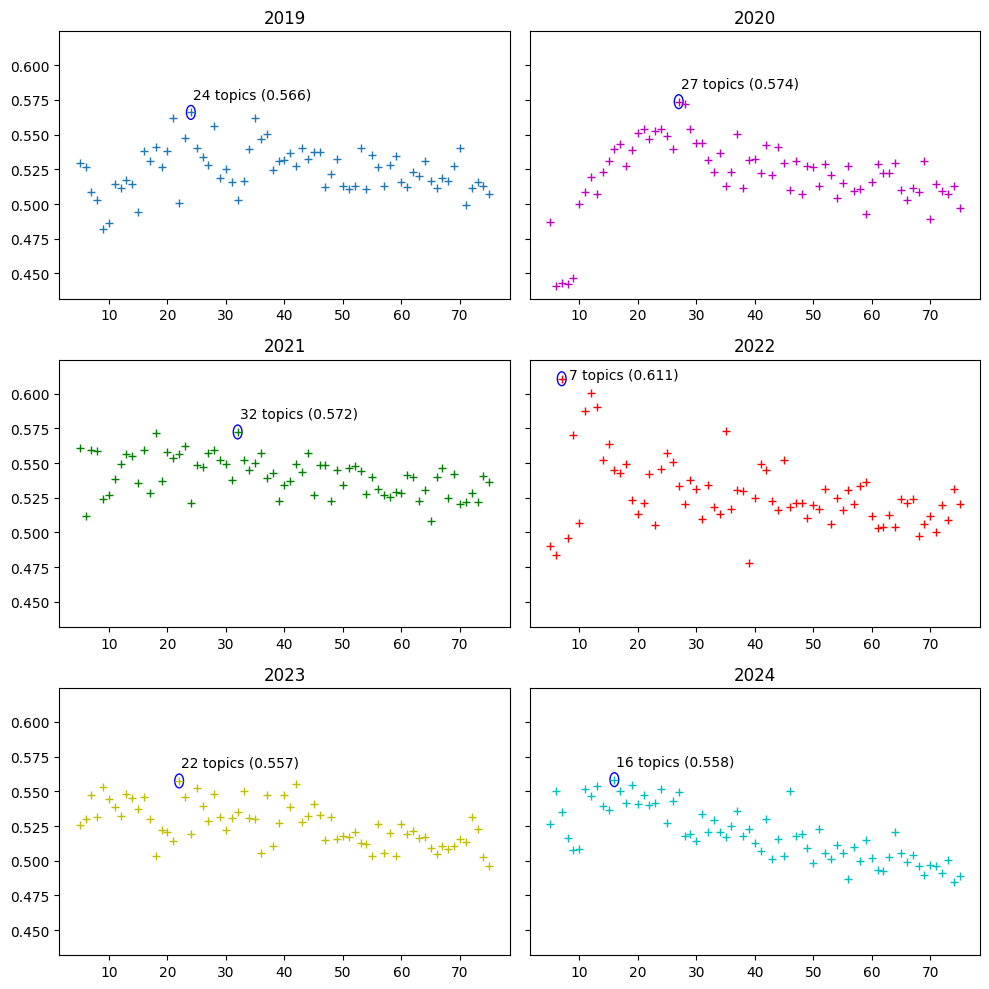

In [119]:
fig, axs = plt.subplots(3, 2, sharey=True, figsize=(10, 10))

axs[0, 0].plot(num_topic_list24, df_coherence['2019'], '+')
axs[0, 0].set_title('2019')
axs[0, 0].annotate(f"{best_num_topic19} topics ({round(best_coherence19,3)}) ",
                xy=(best_num_topic19, df_coherence['2019'][best_num_topic19]), xycoords='data',
                xytext=(1.5, 10), textcoords='offset points')
circle = Ellipse((best_num_topic19, df_coherence['2019'][best_num_topic19]), 1.5, 0.01, color='b', fill=False)
axs[0, 0].add_patch(circle)

axs[0, 1].plot(num_topic_list24, df_coherence['2020'], '+m')
axs[0, 1].set_title('2020')
axs[0, 1].annotate(f"{best_num_topic20} topics ({round(best_coherence20,3)}) ",
                xy=(best_num_topic20, df_coherence['2020'][best_num_topic20]), xycoords='data',
                xytext=(1.5, 10), textcoords='offset points')
circle = Ellipse((best_num_topic20, df_coherence['2020'][best_num_topic20]), 1.5, 0.01, color='b', fill=False)
axs[0, 1].add_patch(circle)

axs[1, 0].plot(num_topic_list24, df_coherence['2021'], '+g')
axs[1, 0].set_title('2021')
axs[1, 0].annotate(f"{best_num_topic21} topics ({round(best_coherence21,3)}) ",
                xy=(best_num_topic21, df_coherence['2021'][best_num_topic21]), xycoords='data',
                xytext=(1.5, 10), textcoords='offset points')
circle = Ellipse((best_num_topic21, df_coherence['2021'][best_num_topic21]), 1.5, 0.01, color='b', fill=False)
axs[1, 0].add_patch(circle)

axs[1, 1].plot(num_topic_list24, df_coherence['2022'], '+r')
axs[1, 1].set_title('2022')
axs[1, 1].annotate(f"{best_num_topic22} topics ({round(best_coherence22,3)}) ",
                xy=(best_num_topic22, df_coherence['2022'][best_num_topic22]), xycoords='data',
                xytext=(5, 0), textcoords='offset points')
circle = Ellipse((best_num_topic22, df_coherence['2022'][best_num_topic22]), 1.5, 0.01, color='b', fill=False)
axs[1, 1].add_patch(circle)

axs[2, 0].plot(num_topic_list24, df_coherence['2023'], '+y')
axs[2, 0].set_title('2023')
axs[2, 0].annotate(f"{best_num_topic23} topics ({round(best_coherence23,3)}) ",
                xy=(best_num_topic23, df_coherence['2023'][best_num_topic23]), xycoords='data',
                xytext=(1.5, 10), textcoords='offset points')
circle = Ellipse((best_num_topic23, df_coherence['2023'][best_num_topic23]), 1.5, 0.01, color='b', fill=False)
axs[2, 0].add_patch(circle)

axs[2, 1].plot(num_topic_list24, df_coherence['2024'], '+c')
axs[2, 1].set_title('2024')
axs[2, 1].annotate(f"{best_num_topic24} topics ({round(best_coherence24,3)}) ",
                xy=(best_num_topic24, df_coherence['2024'][best_num_topic24]), xycoords='data',
                xytext=(1.5, 10), textcoords='offset points')
circle = Ellipse((best_num_topic24, df_coherence['2024'][best_num_topic24]), 1.5, 0.01, color='b', fill=False)
axs[2, 1].add_patch(circle)

#for x in range(0,3):
#    for y in range(0,2):
#        axs[x, y].y_lim(0.3, 0.7)

plt.tight_layout()
plt.show()

In [84]:
df_coherence['2024'][best_num_topic24]

0.5584207122578607

# Avec BERT

In [8]:
try:
    nlp_bert = spacy.load("fr_dep_news_trf")
except OSError:
    !python -m spacy download fr_dep_news_trf
    nlp_bert = spacy.load("fr_dep_news_trf")

In [30]:
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=26112002)

[2025-05-22 16:34:32.282] [CUML] [info] build_algo set to brute_force_knn because random_state is given


In [25]:
pos_model = PartOfSpeech("fr_dep_news_trf")

In [31]:
hdbscan_model = HDBSCAN(min_cluster_size=5, metric='cosine', prediction_data=True)

In [35]:
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

In [45]:
vectorizer_model = CountVectorizer(stop_words=my_stop)

In [46]:
topic_model = BERTopic(embedding_model=nlp_bert.pipe,
                       representation_model=pos_model,
                       umap_model = umap_model,
                       ctfidf_model=ctfidf_model,
                       vectorizer_model = vectorizer_model)

In [47]:
topics, probs = topic_model.fit_transform(df20['texte'])

In [93]:
topic_model.get_topic_info()

Topic  Count                                         Name  \
0      -1   4184                       -1_temps_paris_vie_ans   
1       0    364                    0_min_durée_bande_casting   
2       1    290        1_prison_tribunal_proxénétisme_sursis   
3       2    223      2_femmes_féministes_féminisme_violences   
4       3    151        3_coronavirus_épidémie_patients_virus   
..    ...    ...                                          ...   
68     67     11                                       67____   
69     68     11       68_pronostic_vital_défenestration_coma   
70     69     10              69_escort_girl_colonelle_appels   
71     70     10     70_constitutionnel_vies_mouvance_complot   
72     71     10  71_prévenus_garage_transsexuels_déclaration   

                                       Representation  \
0   [temps, paris, vie, ans, ville, monde, fois, j...   
1   [min, durée, bande, casting, épisode, producti...   
2   [prison, tribunal, proxénétisme, sursis, corre...   
3   [femmes, féministes, féminisme, violences, fém...   
4   [coronavirus, épidémie, patients, virus, pandé...   
..                                                ...   
68                               [, , , , , , , , , ]   
69  [pronostic, vital, défenestration, coma, immeu...   
70  [escort, girl, colonelle, appels, escorts, cli...   
71  [constitutionnel, vies, mouvance, complot, con...   
72  [prévenus, garage, transsexuels, déclaration, ...   

                                  Representative_Docs  
0   [ Un récit d'Anne Gruwez, juge d'instruction à...  
1   [ Trying, Upload, Into The Night, Heder... Vot...  
2   [ vulnérables Guénaèle Calant Ils n'ont eu ni ...  
3   [ Violence, at Stake in the Struggle to End Vi...  
4   [ Le Parisien > L'essentiel En France, on enre...  
..                                                ...  
68                                           [ ., , ]  
69  [ avec AFP Le client d’une jeune prostituée a ...  
70  [ Clémence OUTTERYCK À 17 ans, "Octopus" a déc...  
71  [ Damien Leloup et Grégor Brandy Relativement ...  
72  [ Sudpresse Lecture zen C'est une affaire déjà...  

[73 rows x 5 columns]

In [ ]:
Representative_Docs

In [94]:
topic_model.get_topic_info()['Representative_Docs'][65]

[" Le rôle qui a changé sa vie… Bénédicte Flye Sainte Marie Sorti au printemps  aux États-Unis et quelques mois plus tard en France, Pretty Woman , signé Garry Marshall, est devenu un film culte et a propulsé vers les sommets la carrière de l'actrice. Le rôle qui a changé sa vie… Film - M6 21 h 05 Pretty Woman - Julia Roberts À 52 ans, l'étoile Julia Roberts n'a jamais autant brillé au firmament d'Hollywood. Mais elle ne serait certainement pas l'icône qu'elle est aujourd'hui sans la baguette magique Pretty Woman. En , au moment où elle en débute le tournage, cette brune au sourire ravageur a un CV qui se résume en quelques lignes. Après un bref parcours de mannequin et des spots publicitaires, la toute jeune femme s'est montrée dans les séries Les Incorruptibles de Chicagoet Deux flics à Miamiet a fait des premiers pas remarqués sur grand écran dans Mystic Pizza. Potins de femmes , qui lui vaudra un Golden Globe, n'est pas encore sorti. Elle est donc loin d'être une star incontournabl

In [95]:
topic_model.get_topic_info()['Representation'][65]

['miroir',
 'romantique',
 'collier',
 'alchimie',
 'boulevard',
 'zumba',
 'doublure',
 'film',
 'culte',
 'carats']

In [79]:
linkage_function = lambda x: sch.linkage(x, 'single', optimal_ordering=True)
hierarchical_topics = topic_model.hierarchical_topics(df20['texte'], linkage_function=linkage_function)


100%|███████████████████████████████████████████| 71/71 [32:39<00:00, 27.60s/it]


In [87]:
import plotly.io as pio
pio.renderers.default='iframe'

In [88]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [81]:
tree = topic_model.get_topic_tree(hierarchical_topics)

In [82]:
print(tree)

.
├─■──____ ── Topic: 67
└─min_bande_casting_production_original
     ├─min_bande_casting_production_original
     │    ├─■──miroir_romantique_collier_alchimie_boulevard ── Topic: 64
     │    └─min_bande_casting_production_original
     │         ├─min_bande_casting_production_original
     │         │    ├─■──5th_capitale_bourgmestre_skateboard_fermeture ── Topic: 62
     │         │    └─min_bande_casting_production_original
     │         │         ├─■──crack_tunnel_préfecture_usagers_toxicomanes ── Topic: 61
     │         │         └─min_bande_casting_production_original
     │         │              ├─min_bande_casting_production_original
     │         │              │    ├─min_bande_casting_production_original
     │         │              │    │    ├─min_bande_casting_production_original
     │         │              │    │    │    ├─min_bande_casting_production_original
     │         │              │    │    │    │    ├─min_bande_casting_production_original
     │         │